# TSIA 202-b - Analysis and synthesis of bell sounds

### Arnaud Capitan

This practical work aims to develop a high resolution spectral estimation method in order to perform the analysis / synthesis of bell sounds. As can be noticed in figure 1, this type of sounds presents a strong temporal decrease.

In [695]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [696]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    try :
        if len(data[0]) > 1:
            plt.figure(figsize=(w, h))
            for data_elem in data:
                plt.plot(times,data_elem.reshape(len(data_elem)))
            plt.xlim(xlim1,xlim2)
            plt.xlabel('time (s)')
            plt.ylabel('amplitude')
        else :
            plt.figure(figsize=(w, h))
            plt.plot(times,data.reshape(len(data)))
            plt.xlim(xlim1,xlim2)
            plt.xlabel('time (s)')
            plt.ylabel('amplitude')
            if save:
                plt.savefig(name+'.png', dpi=100)
        plt.show()
    except :
        plt.figure(figsize=(w, h))
        plt.plot(times,data.reshape(len(data)))
        plt.xlim(xlim1,xlim2)
        plt.xlabel('time (s)')
        plt.ylabel('amplitude')
        if save:
            plt.savefig(name+'.png', dpi=100)
        plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [697]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [698]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [699]:
IPython.display.Audio('ClocheB.WAV')

In [700]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

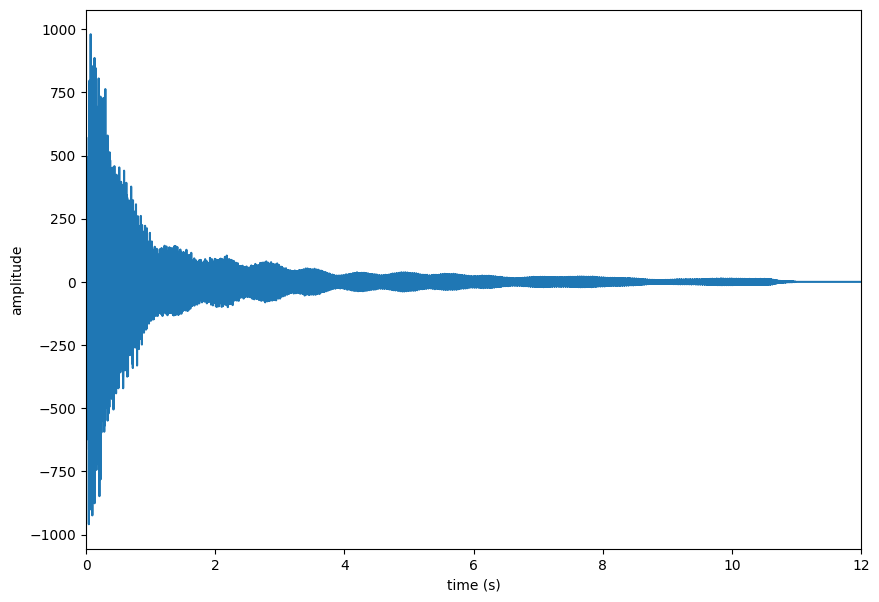

In [701]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [702]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

___

### 3. Synthetic signal

We will use the provided function $\underline{\text{Synthesis}}$ with the following parameters :

$ N = 63, f_0 = \frac{1}{4}, f_1 = f_0 + \frac{1}{N}, a_0 = 1, a_1 = 10, \delta _0 = 0, \delta _1 = -0.05 $

We also draw the phases randomly, such that :

$\phi _0 \sim \mathcal{U}[-\pi,\pi]$ and $\phi _1 \sim \mathcal{U}[-\pi,\pi]$

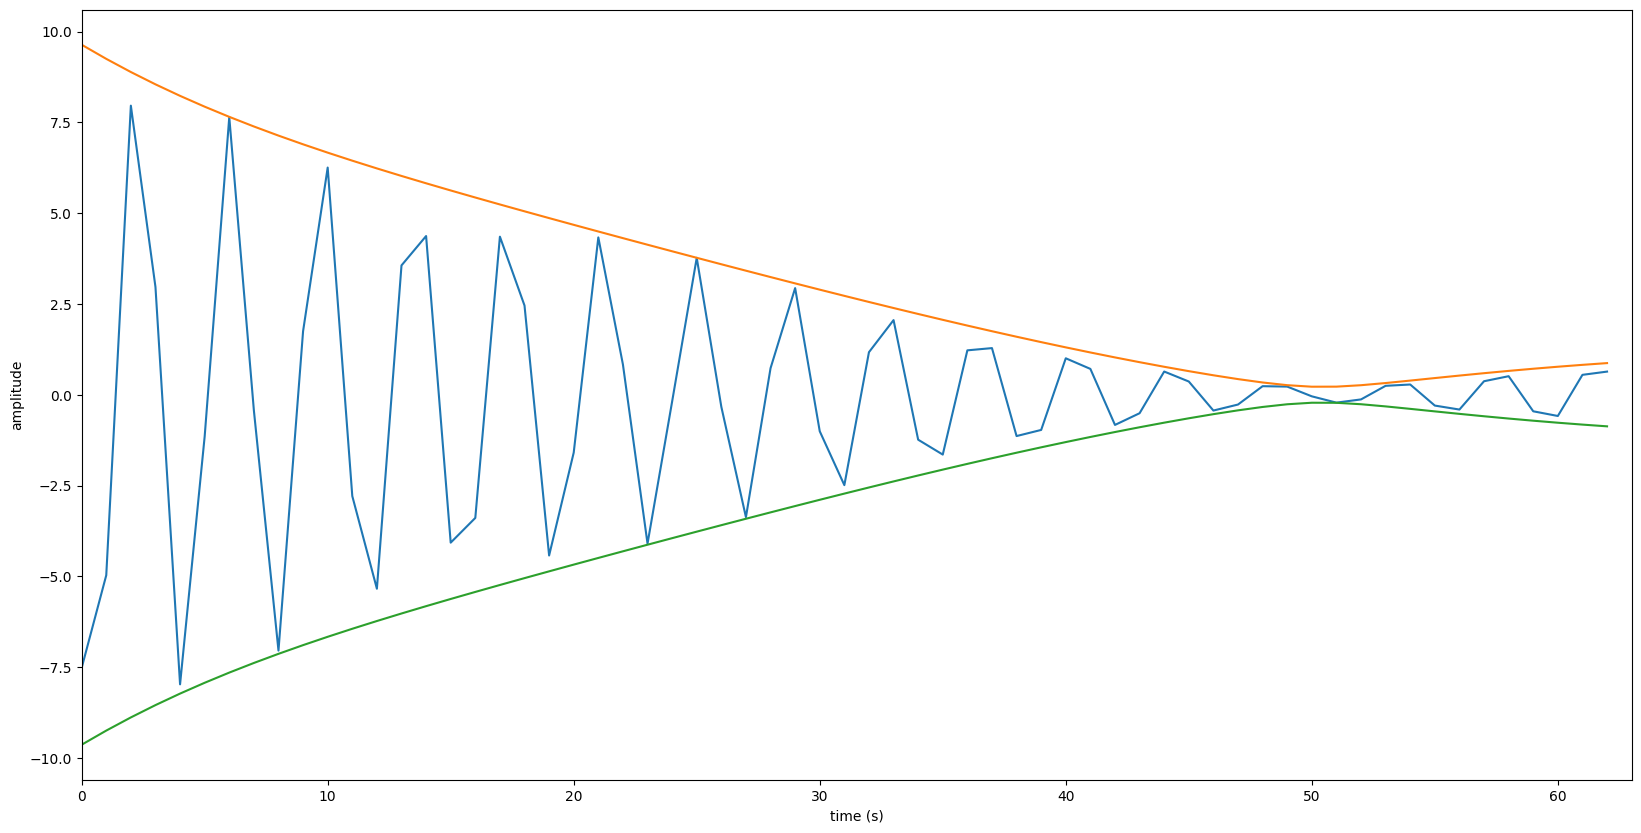

In [703]:
N = 63
delta = np.array([0,-0.05])
freqs = np.array([0.25,0.25+1/63])
a = np.array([1,10])
phi = np.array([np.random.uniform(-np.pi,np.pi),np.random.uniform(-np.pi,np.pi)])

x = Synthesis(N,delta,freqs,a,phi)

timestep = 1
times = np.arange(N)
plot_sound([np.real(x),abs(x),-abs(x)],times,0,N)

### 3.1. Spectral analysis by Fourier transform

To observe the periodogram of this signal, we will use numpy. 

We will then study the separability of the two spectral lines, without zero-padding (Nfft = N) and with zero-padding (Nfft = 1024 > N).

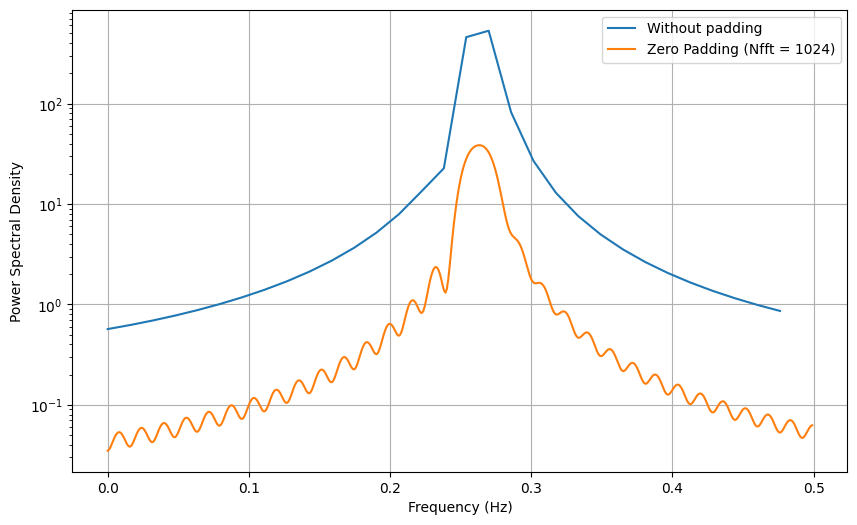

In [704]:
Nfft = 1024
x_padded = np.pad(x,(0,Nfft-len(x)))

fs = 1

n = len(x)
f = np.fft.fftfreq(n, 1/fs)
fft = np.fft.fft(x)
psd = np.abs(fft)**2/n

n_padded = len(x_padded)
f_padded = np.fft.fftfreq(n_padded, 1/fs)
fft_padded = np.fft.fft(x_padded)
psd_padded = np.abs(fft_padded)**2/n_padded

plt.figure(figsize=(10, 6))
plt.semilogy(f[:n//2], psd[:n//2], label='Without padding')
plt.semilogy(f_padded[:n_padded//2], psd_padded[:n_padded//2], label='Zero Padding (Nfft = 1024)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()


The two spectral lines cannot be identified on those plots. We can still argue that even if the PSD with zero-padding is a lot smoother than without, it is much less precise in terms of amplitude.

Nonetheless, if we only plot the scattered plot, we have the two frequencies we are trying to find by looking at the PSD without padding, and we are quite close to the correct values.

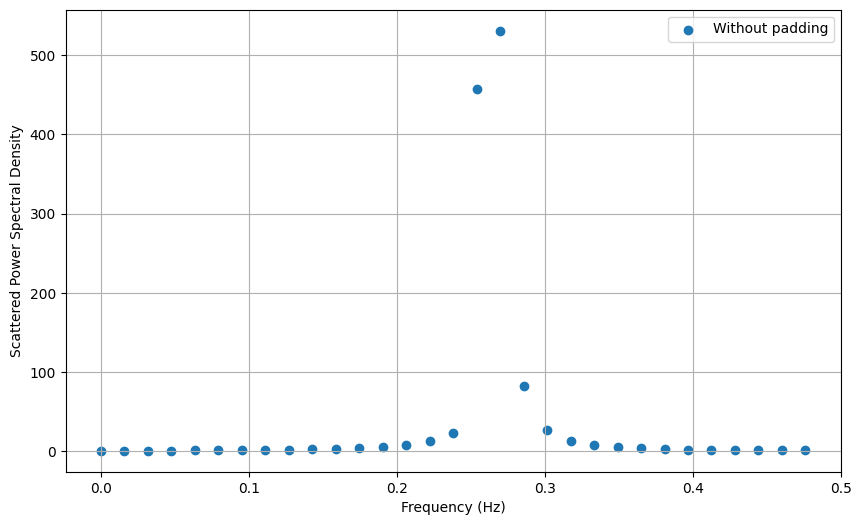

First frequency : 0.25397, frequency expected : 0.25, error : 0.00397
Second frequency : 0.26984, frequency expected : 0.26587, error : error : 0.00397


In [705]:
plt.figure(figsize=(10, 6))
plt.scatter(f[:n//2], psd[:n//2], label='Without padding')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Scattered Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

print(f"First frequency : {f[list(psd).index(max(psd))-1]:.5f}, frequency expected : {0.25}, error : {(f[list(psd).index(max(psd))-1]-0.25):.5f}")
print(f"Second frequency : {f[list(psd).index(max(psd))]:.5f}, frequency expected : {(0.25+1/63):.5f}, error : error : {(f[list(psd).index(max(psd))]-(0.25+1/63)):.5f}")

___

### 3.2. High resolution methods


In [706]:
def hankel_matrix(x, n, l):
    return np.array([x[i:i+l] for i in range(n)])

def empirical_covariance(X):
    l = X.shape[1]
    return X @ X.conj().T/l

def subspace(Rxx,K):
    U1, Lambda, U2 = np.linalg.svd(Rxx)
    W = U1[:, :K] #Subspace of dimension K
    W_orth = U1[:, K:] #Subspace of noise
    return(W,W_orth)

### 3.2.1. ESPRIT method

#### 3. Estimation of the frequencies and damping factors

In [707]:
def extract_matrices(W):
    W_down = W[:-1, :] #We remove the last row
    W_up = W[1:, :] #We remove the first row
    return W_down, W_up

def compute_phi(W_down, W_up):
    phi = np.linalg.pinv(W_down)@W_up
    return phi

def compute_parameters(phi):
    z = np.linalg.eigvals(phi)
    delta_k = np.log(abs(z))
    f_k = np.angle(z)/(2*np.pi)
    return delta_k, f_k

def ESPRIT(x, n, K):
    l = len(x)-n+1 # N = n + l - 1
    X = hankel_matrix(x, n, l)
    Rxx = empirical_covariance(X)
    W, _ = subspace(Rxx, K)
    W_down, W_up = extract_matrices(W)
    Phi = compute_phi(W_down, W_up)
    delta_k, f_k = compute_parameters(Phi)
    return delta_k, f_k

#### 4. Estimation of the amplitudes and phases

We have $ \alpha _k = a_k e^{i\phi _k} $ for the complex amplitudes, and we aim to find $\alpha _k$ and $\phi _k$

The complex poles are given since we have the damping factirs and the frequencies :

$$ z_k = e^{\delta _k + 2i\pi f_k} $$

Thus obtaining the following form :

$$ s[t] = \sum _{k=0} ^{K-1} \alpha _k z_k ^t $$

The complex amplitudes are determined by the equation :

$$ \alpha = ((V^{N^H}V^N)^{-1}V^{N^H})x $$


In [708]:
def LeastSquares(x,delta,f):
    N = len(x)
    K = len(delta) # K should also be len(f)
    z = np.exp(delta+2j*np.pi*f)
    V = np.zeros((N,K))
    V = 1j*V
    for i in range(N):
        for k in range(K):
            V[i,k] = z[k]**i
    alpha = np.linalg.pinv(V) @ x
    a = abs(alpha)
    phi = np.angle(alpha)
    return(a,phi)
    

#### 5. Application to synthetic signals

We then apply our functions ESPRIT and LeastSquares to our previously synthesized signal.

In [709]:
estimated_delta, estimated_freq = ESPRIT(x,n = 32,K = 2)
print(f"Estimated delta : {[elem for elem in estimated_delta]}")
print(f"Exact delta  : {delta}\n")

print(f"Estimated freq : {[elem for elem in estimated_freq]}")
print(f"Exact freq  : {freqs}")

Estimated delta : [-0.050000000000000926, -2.2204460492503136e-16]
Exact delta  : [ 0.   -0.05]

Estimated freq : [0.2658730158730158, 0.24999999999999997]
Exact freq  : [0.25       0.26587302]


We can see that the ESPRIT method gives the correct frequencies and damping values for our previously synthetised signal, and that the error is really small for both delta and the frequencies.

In [710]:
estimated_a, estimated_phi = LeastSquares(x,estimated_delta,estimated_freq)
print(f"Estimated a : {[elem for elem in estimated_a]}")
print(f"Exact a  : {a}\n")

print(f"Estimated phi : {[elem for elem in estimated_phi]}")
print(f"Exact phi  : {phi}")

Estimated a : [10.00000000000011, 1.0000000000000058]
Exact a  : [ 1 10]

Estimated phi : [2.371492402509018, -1.924266348487258]
Exact phi  : [-1.92426635  2.3714924 ]


We get the correct results for our LeastSquares function on the previously synthesized signal, using the estimated parameters delta and freqs.

___
### 3.2.2. MUSIC Method

The MUSIC pseudo-spectrum is defined as :

$$ P(z) = \frac{1}{||W^H_⊥ \nu ^n (z)||^2} $$

Where $W_⊥$ represents the noise subspace

We recall that $ z = e^{\delta + 2i\pi f}$

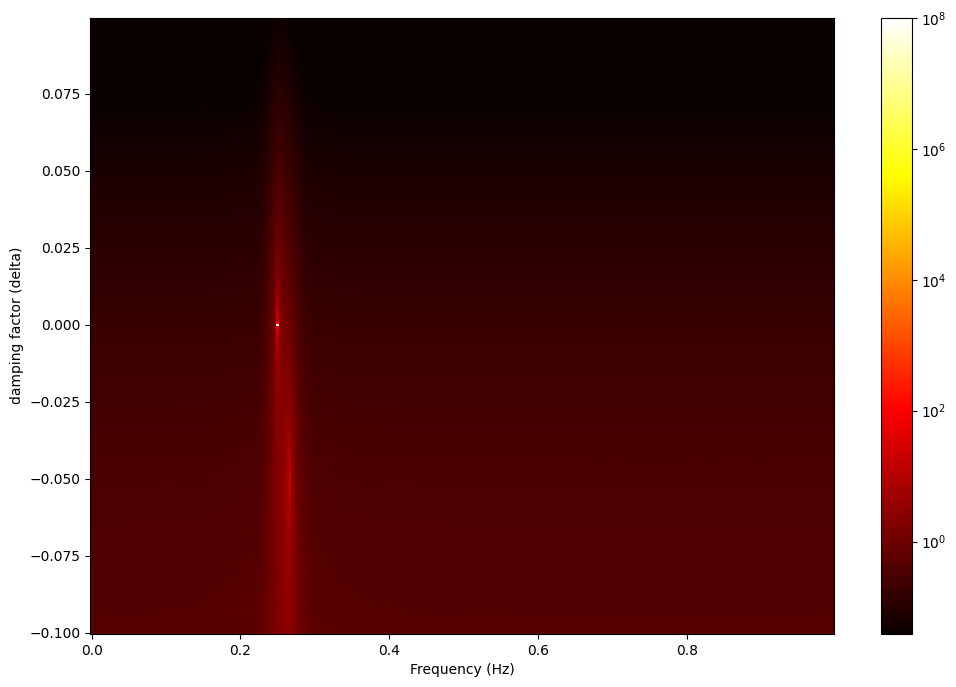

In [711]:
def MUSIC(x,n,K):
    l = len(x)-n+1 # N = n + l - 1
    X = hankel_matrix(x, n, l)
    Rxx = empirical_covariance(X)
    _, W_orth = subspace(Rxx, K)
    res = 300
    freq_plot = np.arange(0,1,1/res)
    delta_plot = np.arange(-0.1,0.1,0.2/res)
    pseudo_spectrum = np.zeros((len(freq_plot),len(delta_plot)))
    for (i,delta1) in enumerate(delta_plot):
        for (j,freq1) in enumerate(freq_plot):
            z = np.exp(delta1+2j*np.pi*freq1)
            nu = 1j*np.zeros((1,n)) #To keep the complex values
            for k in range(n):
                nu[:,k] = z**k
            pseudo_spectrum[i,j] = 1/np.linalg.norm(W_orth.conj().T @ nu.T)
    plt.figure(figsize=(12,8))
    plt.pcolormesh(freq_plot, delta_plot, pseudo_spectrum, vmin=pseudo_spectrum.min()*2, cmap='hot', vmax = 10**8, norm = 'log')
    plt.colorbar()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('damping factor (delta)')
    plt.show()

MUSIC(x,32,2)

We clearly see the first root $z_0 = e^{\delta _0 + 2i\pi \nu _0}$ with $\delta _0 = 0, \nu _0 = 0.25$.

We can also see a second hot point for the second root : $z_1 = e^{\delta _1 + 2i\pi \nu _1}$ with $\delta _1 = -0.05, \nu _1 = 0.27$

MUSIC gives us the correct values (since we have the exact values we can see that it works), but we do not have the exact precise values. ESPRIT gives the correct values.

This method allows us to plot the pseudo-spectrum of our signal, even if the values aren't as much precise as the ESPRIT method. I plotted this graph using log scale and a max value so that the other root can also be seen on the plot.
___


## 4. Audio signals

We will now apply our functions to bell sounds.

### 4.1. Spectral analysis by Fourier transform

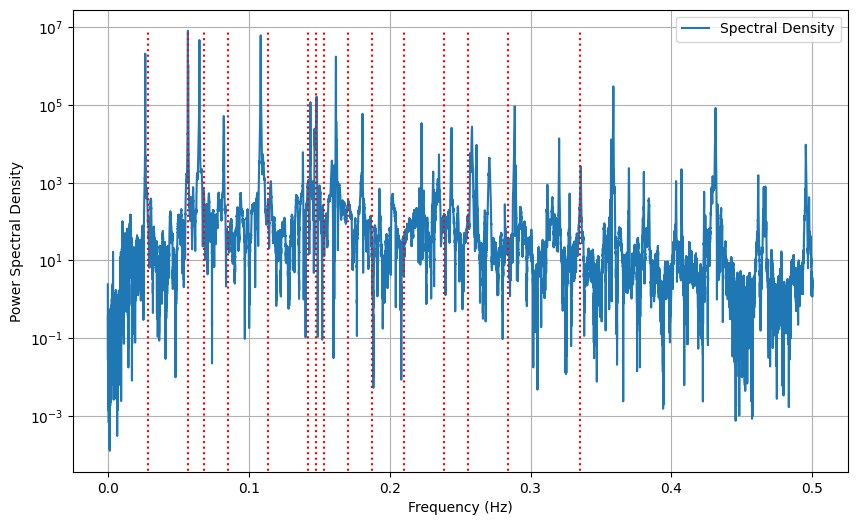

In [712]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
n = len(data)
x = np.array(data)
len_x = x.shape[1]
x = x.reshape(len_x)

fs=1
n = len(x)
f = np.fft.rfftfreq(n, 1/fs)
fft = np.fft.rfft(x)
psd = np.abs(fft)**2/n

max_freq = (f[:n//2])[list(psd[:n//2]).index(max(psd[:n//2]))] # Fundamental / prime frequency
max_psd = max(psd[:n//2])
ratios = [0.5,1,1.2,1.5,2,2.5,2.6,2.7,3,3.3,3.7,4.2,4.5,5,5.9]

plt.figure(figsize=(10, 6))
plt.semilogy(f[:n//2], psd[:n//2], label='Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.vlines(max_freq*np.array(ratios),ymin = [0 for i in range(len(ratios))], ymax = [max_psd for i in range(len(ratios))], colors=['red' for i in range(len(ratios))], linestyles=['dotted' for i in range(len(ratios))])
plt.legend()
plt.grid(True)
plt.show()



We can observe that the eigenfrequencies are close to the ones given in the introduction (red lines, taking the prime frequency as the frequency where the power spectral density reaches its maximum value).

### 4.2 High resolution method

We now want to apply the ESPRIT method to this signal. Let K = 54, n = 512 and l = 2n = 1024 (hence N = n + l − 1 = 1535).

Since we only take a fragment of the signal, there may be dampening factors that are positive, thus creating an instable signal (since the amplitude diverges). We remove those by setting them to $\delta_{>0} = -0.0001$


In [713]:
x_segment = x[10000:11535]
delta, freqs = ESPRIT(x_segment,n=512,K=54)
delta = np.real(delta)

### Explanation above
for i in range (len(delta)):
    if delta[i] > 0:
        delta[i] = -0.0001
###

a, phi = LeastSquares(x_segment,delta,freqs)
y = Synthesis(len_x,delta,freqs,a,phi)
IPython.display.Audio(y, rate=sampling_frequency)

c:\Users\Arnaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\lib\display.py:172: ComplexWarning:

Casting complex values to real discards the imaginary part



In [714]:
IPython.display.Audio('ClocheA.WAV')

Apart from the sound behind overall clearer and louder, the reasonance lasts much longer with our resynthesised signal than with the original one.

We can also compare the periodograms with the exact frequencies :

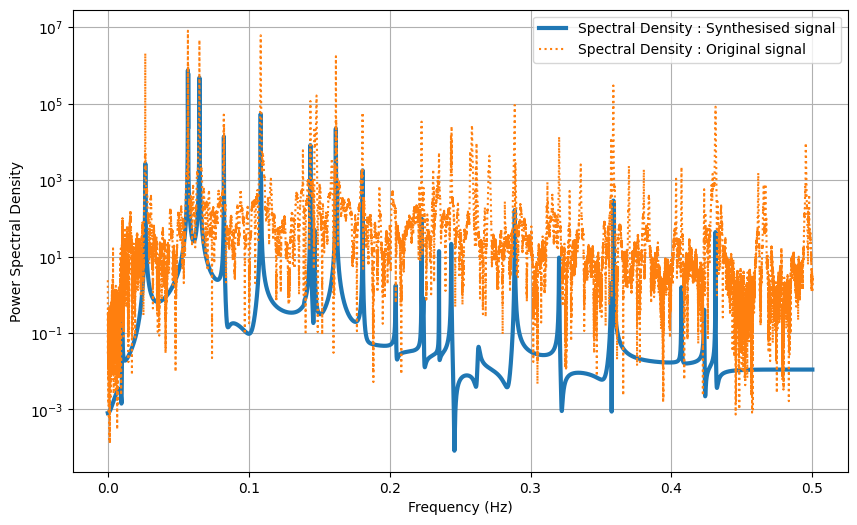

In [715]:
n_y = len(y)
f_y = np.fft.rfftfreq(n_y, 1/fs)
fft_y = np.fft.rfft(y)
psd_y = np.abs(fft_y)**2/n_y

plt.figure(figsize=(10, 6))
plt.semilogy(f_y[:n_y//2], psd_y[:n_y//2], label='Spectral Density : Synthesised signal', linewidth=3)
plt.semilogy(f[:n//2], psd[:n//2], label='Spectral Density : Original signal', linestyle='dotted')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

We can see that the synthesised signal only has the frequencies corresponding to the highest PSD, and smoothes out the other frequencies that were either noise or dampening the signal, thus obtaining such a clear bell sound with our synthesised bell sound.

We can plot the sound obtained, and compare it to the sound we initially had :

In [717]:
def plot_sound_Cloche_A():
    _, data, _, _, _ = read_values('ClocheA.WAV')
    Fs = int(wavefile.getframerate())
    x = np.array(data)
    len_x = x.shape[1]
    timestep = 1/(float(Fs))
    times = np.arange(len_x)*timestep
    plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

def plot_synthesised_sound_Cloche_A():
    y = Synthesis(len_x,delta,freqs,a,phi)
    Fs = sampling_frequency
    timestep = 1/(float(Fs))
    times = np.arange(len(y))*timestep
    plot_sound(y.reshape(len(y)), times,0,12,w=10,h=7)

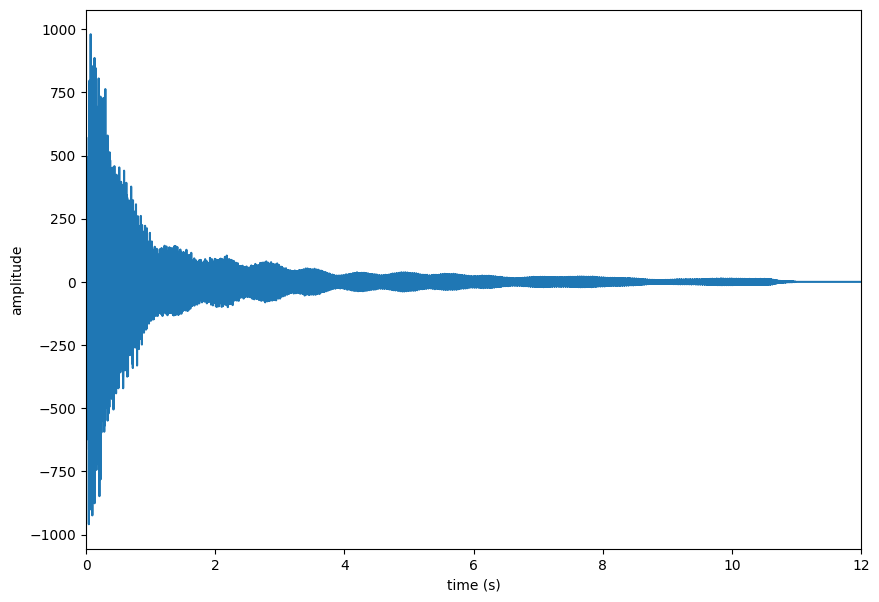

c:\Users\Arnaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\Users\Arnaud\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning:

Casting complex values to real discards the imaginary part



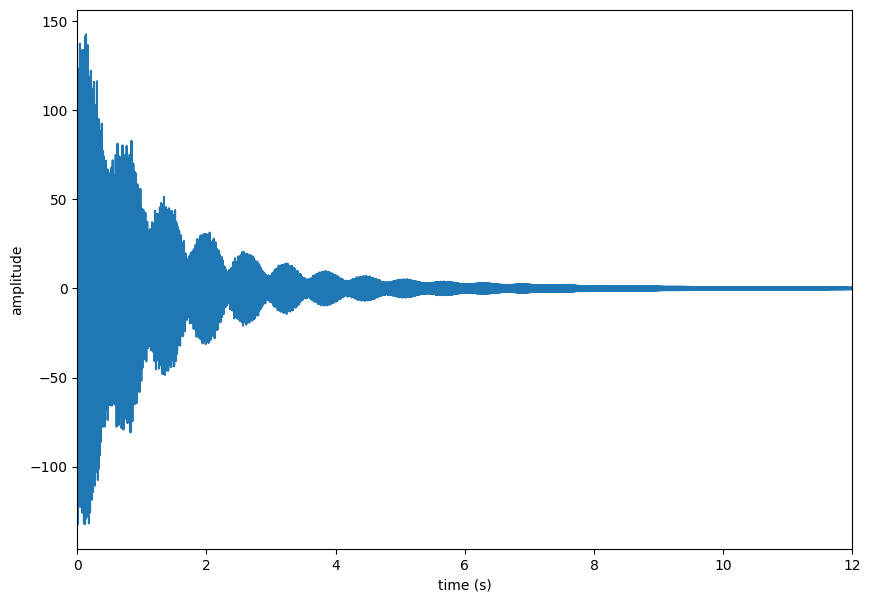

In [718]:
plot_sound_Cloche_A()
plot_synthesised_sound_Cloche_A()